In [25]:
import warnings
warnings.filterwarnings('ignore')

In [56]:
import logging
logging.basicConfig(level=logging.ERROR)
import numba
from numba import jit,njit, cuda
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import scipy.sparse as sp
import networkx as nx
from scipy.sparse import coo_matrix
from sklearn.metrics import roc_auc_score, f1_score, recall_score,precision_score, accuracy_score,average_precision_score,precision_recall_curve,auc
from tqdm import tqdm
import numpy as np
from torch.nn import Parameter
import torch.optim as optim
import pdb
import time
from dgllife.utils import EarlyStopping, Meter
import pickle
import re
from collections import defaultdict
import json
import hypernetx as hnx
import random
from dgllife.data import Tox21, ClinTox, ToxCast
from dgllife.utils import SMILESToBigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from dgllife.utils import mol_to_graph
from dgllife.utils import mol_to_bigraph

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load and save Tox21 dataset

In [58]:
#Convert SMILES notation into graphs with initial featurizations for nodes and edges;
#Load the dataset Tox21 with these graphs. 
path = './datasets/saved_tox21_dataset.pt'
if not os.path.exists(path):
    start_time = time.time()
    smiles_to_g = SMILESToBigraph(node_featurizer=CanonicalAtomFeaturizer())
    dataset = Tox21(smiles_to_g)
    end_time = time.time()
    print(f'Load time = {end_time - start_time}')
    torch.save(dataset, save_path)

# load saved dataset
start_time = time.time()
dataset = torch.load(path)
end_time = time.time()
print(f"Dataset loaded from {path}")
print(f'Load time = {end_time - start_time}')

Dataset loaded from ./datasets/saved_tox21_dataset.pt
Load time = 1.3645381927490234


# Extract graphs and labels

In [66]:
graphs = [graph for graph in dataset]
label_data=[graph[2] for graph in dataset]

In [75]:
# increase the data rate limit for Jupyter Notebook
!jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000
# generate the jupyter notebook config file
!jupyter notebook --generate-config

/home/jnguyen89/miniconda3/envs/thtn/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=3539139) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


[I 2024-10-21 04:31:50.863 ServerApp] jupyter_lsp | extension was successfully linked.
[I 2024-10-21 04:31:50.865 ServerApp] jupyter_server_terminals | extension was successfully linked.
[W 2024-10-21 04:31:50.866 LabApp] 'iopub_data_rate_limit' has moved from NotebookApp to ServerApp. This config will be passed to ServerApp. Be sure to update your config before our next release.
[W 2024-10-21 04:31:50.868 ServerApp] ServerApp.iopub_data_rate_limit config is deprecated in 2.0. Use ZMQChannelsWebsocketConnection.iopub_data_rate_limit.
[I 2024-10-21 04:31:50.868 ServerApp] jupyterlab | extension was successfully linked.
[W 2024-10-21 04:31:50.871 ServerApp] ServerApp.rate_limit_window config is deprecated in 2.0. Use ZMQChannelsWebsocketConnection.rate_limit_window.
[I 2024-10-21 04:31:50.871 ServerApp] notebook | extension was successfully linked.
[I 2024-10-21 04:31:50.994 ServerApp] notebook_shim | extension was successfully linked.
[I 2024-10-21 04:31:51.004 ServerApp] notebook_shim 

In [111]:
# create the dictionary file from scratch
def process_text_to_dict(file_path):
    # Open and read the file
    with open(file_path, "r") as file:
        # Read the entire file content
        data = file.read()
    # Initialize a defaultdict to store graph IDs and their corresponding subgraph IDs
    graph_dict = defaultdict(list)
    
    # Split the data by the delimiter (dashed line)
    subgraphs = data.strip().split('-----------------')
    
    # Exclude the last part where the time taken is printed
    for subgraph in subgraphs[:-1]:
        lines = subgraph.strip().splitlines()
        
        # Get the subgraph ID (first line starts with 't #')
        subgraph_id = int(lines[0].split('#')[1].strip())
        
        # Get the list of graph IDs (the last line starts with 'Subgraph appears in graph IDs:')
        for line in lines:
            if line.startswith("Subgraph appears in graph IDs:"):
                graph_ids = eval(line.split(":")[1].strip())  # Safely evaluate the list
                for graph_id in graph_ids:
                    graph_dict[graph_id].append(subgraph_id)
    
    graph_dict = dict(sorted(graph_dict.items()))
    
    # Print the result
    for graph_id, subgraph_ids in graph_dict.items():
        print(f"{graph_id}: {subgraph_ids}")

    return graph_dict

file_path = "./jt_output_700.txt"
# file_path = "./gspan_outputs/meaningful_subgraphs_700.txt"
# file_path = "./gspan_outputs/jt_test_output_100.txt"

result = process_text_to_dict(file_path)

# Pickle the dictionary
with open('result_jt_700.pkl', 'wb') as file:
    pickle.dump(result, file)

0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
1: [8, 9, 11]
2: [0, 1, 2, 4, 5, 6, 7, 8, 10]
3: [0, 1, 2, 4, 5, 6, 7, 8, 10]
4: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
5: [11]
12: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
13: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
14: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
15: [0, 1, 3, 4, 5, 7, 8, 9, 10, 11]
16: [0, 1, 3, 8, 9, 11]
17: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
19: [11]
20: [0, 1, 2, 8, 10, 12, 13]
21: [0, 1, 2, 4, 7, 8, 10]
22: [0, 1, 8, 11, 12, 13]
23: [0, 1, 3, 8, 9, 10, 11, 12, 13]
24: [8, 13]
25: [0, 1, 3, 8, 9, 11, 12, 13]
26: [8, 13]
27: [0, 1, 2, 4, 5, 6, 7, 8, 10]
28: [0, 1, 2, 4, 5, 6, 7, 8, 10]
29: [0, 1, 2, 4, 5, 6, 7, 8, 10]
30: [0, 1, 2, 4, 5, 6, 7, 8, 10]
31: [8, 9, 11]
32: [0, 1, 2, 4, 5, 6, 7, 8, 10]
33: [0, 1, 2, 4, 5, 6, 7, 8, 10]
34: [0, 1, 2, 4, 5, 6, 7, 8, 10]
35: [0, 1, 2, 4, 5, 6, 7, 8, 10]
36: [8, 10]
37: [0, 1, 2, 4, 7, 8, 10]
38: [0, 1, 2, 8, 10]
39: [0, 1, 2, 3, 8, 9, 10, 11]
40: [0, 1, 2, 8, 10]
41: [0,

# Load dictionary files

In [121]:
# when dict in pickle format
file_path = 'result_raw_700.pkl'
with open(file_path, 'rb') as file:
    DICT = pickle.load(file)
    
# # when the dict in json format
# import json
# file_path = 'result.json'
# with open(file_path, 'r') as file:
#     DICT = json.load(file)

#  Visualizing the hypergraph

Processing edges: 100%|██████████| 5/5 [00:00<00:00, 1695.22it/s]


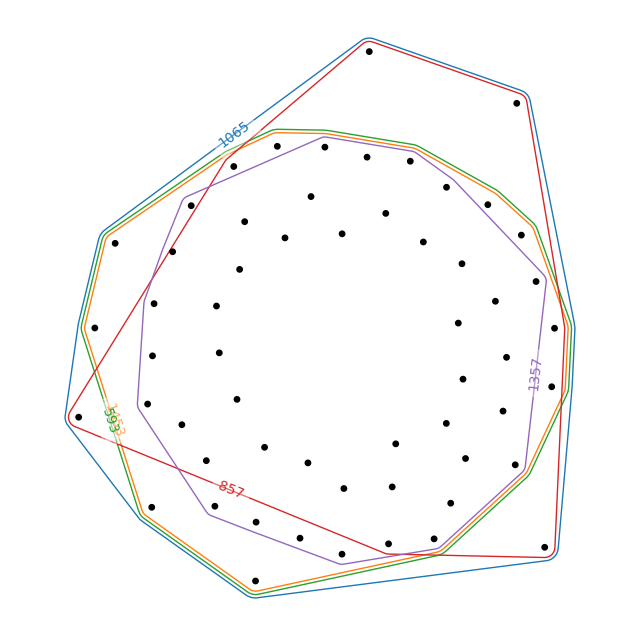

In [122]:
# Dictionary
hypergraph_dict = DICT

# Create the hypergraph
H = hnx.Hypergraph(hypergraph_dict)

# # Save the hypergraph to a file
# with open('hypergraph_raw_700.pkl', 'wb') as f:
#     pickle.dump(H, f)

# # Load the hypergraph from a file
# with open('hypergraph_raw_700.pkl', 'rb') as f:
#     H = pickle.load(f)

# Get the list of hyperedges
hyperedges = list(H.edges())

# Limit the number of hyperedges to be drawn
max_hyperedges = 5  # Set the desired limit
if len(hyperedges) > max_hyperedges:
    sampled_hyperedges = random.sample(hyperedges, max_hyperedges)
else:
    sampled_hyperedges = hyperedges

# Create a subset dictionary
subset_hypergraph_dict = {k: H.edges[k] for k in sampled_hyperedges}

# Create a new hypergraph using the subset
H_subset = hnx.Hypergraph(subset_hypergraph_dict)

# Draw the hypergraph
hnx.draw(H_subset, layout=nx.spring_layout, layout_kwargs={'k': 0.3, 'iterations': 50}, node_radius=0.5, node_labels_kwargs={'fontsize': 3}, edge_labels_kwargs={'fontsize': 10}, with_node_labels=False, with_edge_labels=True)


# Processing the data

In [123]:
'''
converting to sparse matrix
'''
LEN=len(DICT)
nl=coo_matrix((LEN, LEN))
nl.setdiag(1)
values = nl.data
indices = np.vstack((nl.row, nl.col))
i = torch.FloatTensor(indices)
# v = torch.FloatTensor(values)
v = torch.FloatTensor(values)
shape = nl.shape
nl=torch.sparse_coo_tensor(i, v, torch.Size(shape))

In [124]:
LEN=len(DICT)
nl=np.eye(LEN)
nl=torch.from_numpy(nl)

In [125]:
'''
Then we are using the DICT to create a hyG. Drug=sequence=molecule=Hyperedge and subsequence=substructure=node
'''
molec_list = []
chemicalsub_list = []
molec_chemicalsub = {}
#chemicalsub_drug = {}

for molec in tqdm(DICT.keys(), desc='Loading dictionary') :
    chemicalsubs = DICT[molec]
    if molec not in molec_list :
        molec_list.append(molec)
    idx = molec_list.index(molec)
    if idx not in molec_chemicalsub :
        molec_chemicalsub[idx]=[]

    translated_p = []

    for chemicalsub in chemicalsubs:
        if chemicalsub not in chemicalsub_list :
            chemicalsub_list.append(chemicalsub)
        p_idx = chemicalsub_list.index(chemicalsub)
        translated_p.append(p_idx) # translate chemicalsub number into index

    molec_chemicalsub[idx]=translated_p

'''
chemicalsub : corresponds to hypernode
citing : corresponds to hyperedge(molec)
'''

chemicalsub_citing = [] # list of [chemicalsub molec]
n_chemicalsub = len(chemicalsub_list)
n_hedge = len(molec_list)

for molec in tqdm(molec_chemicalsub.keys(), desc='Loading molecules'):
    chemicalsubs = molec_chemicalsub[molec]
    for chemicalsub in chemicalsubs :
        chemicalsub_citing.append([chemicalsub, molec])

chemicalsub_molec = torch.LongTensor(chemicalsub_citing)
data_dict = {
        ('node', 'in', 'edge'): (chemicalsub_molec[:,0], chemicalsub_molec[:,1]),
        ('edge', 'con', 'node'): (chemicalsub_molec[:,1], chemicalsub_molec[:,0])
    }

'''
finally passing the data_dict to construct hyG
'''

lst=[]
for i in tqdm(chemicalsub_citing, desc='Constructing hypergraph'):
  lst.append(i[0])
s=set(lst)
s=len(s)
num_nodes_dict = {'edge': LEN,'node':s}
hyG = dgl.heterograph(data_dict,num_nodes_dict=num_nodes_dict)
rows=n_chemicalsub
columns=n_hedge
'''
reading the feature (one hot coding) for molecs (edges)
'''

molec_X=nl
v_feat=coo_matrix((rows, 128))
v_feat.setdiag(1)
#nl.toarray()
values = v_feat.data
indices = np.vstack((v_feat.row, v_feat.col))
i = torch.FloatTensor(indices)
# v = torch.FloatTensor(values)
v = torch.FloatTensor(values)
shape = v_feat.shape
v_feat=torch.sparse_coo_tensor(i, v, torch.Size(shape))

hyG.ndata['h'] = {'edge' : molec_X.type('torch.FloatTensor'), 'node' : v_feat.type('torch.FloatTensor')}
e_feat = molec_X.type('torch.FloatTensor')
v_feat=v_feat.type('torch.FloatTensor')

e_feat = e_feat.to(device)
v_feat = v_feat.to(device)
hyG=hyG.to(device)

Constructing hypergraph: 100%|██████████| 54319/54319 [00:00<00:00, 6336895.36it/s]


# Apply HyGNN

In [126]:
class hypergraph_NN(nn.Module):
    def __init__(self, i_d, q_d, v_d, e_d, num_class, dropout = 0.5):
        super(hypergraph_NN, self).__init__()
        self.dropout = dropout

        self.q_d = q_d
        self.first_layer_in = torch.nn.Linear(i_d, v_d)
        self.not_first_layer_in = torch.nn.Linear(v_d, v_d)

        self.w1 = torch.nn.Linear(e_d, q_d)
        self.w2 = torch.nn.Linear(v_d, q_d)
        self.w3 = torch.nn.Linear(v_d, e_d)
        self.w4 = torch.nn.Linear(v_d, q_d)
        self.w5 = torch.nn.Linear(e_d, q_d)
        self.w6 = torch.nn.Linear(e_d, v_d)
        self.cls = nn.Linear(e_d, num_class)
    def red_function(self, nodes):
        attention_score = F.softmax((nodes.mailbox['Attn']), dim=1)
        aggreated = torch.sum(attention_score.unsqueeze(-1) * nodes.mailbox['v'], dim=1)
        return {'h': aggreated}
    def attention(self, edges):
        attention_score = F.leaky_relu((edges.src['k'] * edges.dst['q']).sum(-1))
        c=attention_score/np.sqrt(self.q_d)
        return {'Attn': c}
    def msg_function(self, edges):
        return {'v': edges.src['v'], 'Attn': edges.data['Attn']}

    def forward(self, hyG, vfeat, efeat,first_layer,last_layer):
        with hyG.local_scope():
            if first_layer:
                feat_e = self.first_layer_in(efeat)
            else:
                feat_e = self.not_first_layer_in(efeat)
            feat_v = vfeat

            # Hyperedge attention
            hyG.ndata['h'] = {'edge': feat_e}
            hyG.ndata['k'] = {'edge' : self.w5(feat_e)}
            hyG.ndata['v'] = {'edge' : self.w6(feat_e)}
            hyG.ndata['q'] = {'node' : self.w4(feat_v)}
            hyG.apply_edges(self.attention, etype='con')
            hyG.update_all(self.msg_function, self.red_function, etype='con')
            feat_v = hyG.ndata['h']['node']

            # node attention
            hyG.ndata['k'] = {'node' : self.w2(feat_v)}
            hyG.ndata['v'] = {'node' : self.w3(feat_v)}
            hyG.ndata['q'] = {'edge' : self.w1(feat_e)}
            hyG.apply_edges(self.attention, etype='in')
            hyG.update_all(self.msg_function, self.red_function, etype='in')
            feat_e = hyG.ndata['h']['edge']


            if not last_layer :
                feat_v = F.dropout(feat_v, self.dropout)
            if last_layer:
                pred=self.cls(feat_e) #to reduce the hyperedge feature into 'c' dimension, where c is the number of class
                return pred
            else:
                return [hyG, feat_v, feat_e]

In [127]:
labels = torch.stack([label for label in label_data]).float()
label=label_data[0].tolist()
num_class=len(label)

In [128]:
num_epochs = 100
patience_limit = 10
file_path = 'hyGNN_results_post.csv'

In [129]:
for i in range(5):
    print(f'Test #{i + 1}:')
    results = []
    model =hypergraph_NN(molec_X.shape[1], 64, 128, 128,  num_class, 0.3)
    model=model.to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    patience=0
    
    # Ensure the relevant features are of type Float
    v_feat = v_feat.float()
    e_feat = e_feat.float()
    
    start_time = time.time()
    min_loss = 1
    max_loss = 0
    
    for epoch in tqdm(range(num_epochs), desc='Training progress'):
        model.train()
        train_meter = Meter()
        total_loss = 0
        
        pred = model(hyG, v_feat, e_feat, True,True)
        
        keys = list(range(7831))
        f_pred = []
        f_labels = []
        
        # Filter predictions and labels based on the presence of keys in DICT
        for key, pred_item, label in zip(keys, pred, labels):
            if key in DICT:
                f_pred.append(pred_item)
                f_labels.append(label)
        # print(len(f_labels))
        label=label_data[0].tolist()
        num_class=len(label)
    
        f_labels = torch.stack([label for label in f_labels]).float()
        
        from sklearn.model_selection import train_test_split
        train_label, test_label= train_test_split(f_labels,test_size=0.1, random_state=42)
        train_label=torch.tensor(train_label,dtype=torch.float).to(device)
        
        size=int((LEN)*0.1)
        val_label=train_label[0:size]
        train_label=train_label[size:]
        test_label=torch.tensor(test_label,dtype=torch.float).to(device)
    
        train_pred, test_pred= train_test_split(f_pred,test_size=0.1, random_state=42)
        val_pred=train_pred[0:size]
        train_pred=train_pred[size:]
    
        train_pred = torch.stack(train_pred)
        val_pred = torch.stack(val_pred)
        test_pred = torch.stack(test_pred)
        
         # Ensure the shapes match
        assert train_pred.shape == train_label.shape, "Prediction and label shapes do not match"
        
        loss = loss_fn(train_pred, train_label)
        # Convert logits to binary predictions using a threshold of 0.5
        pred_cls = (train_pred > 0).float()
        correct = torch.eq(pred_cls, train_label).sum().item()
        total = train_label.numel()
        train_acc = correct / total
    
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_meter.update(train_pred, train_label)
        print(f"Loss: {loss.item():.4f}, Training Accuracy: {train_acc: .4f}")
        
        with torch.no_grad():
          model.eval()
          val_cls = (val_pred > 0).float()
          correct = torch.eq(val_cls, val_label).sum().item()
          total = val_label.numel()
          val_acc = correct / total
    
          # Save the best validation accuracy and the corresponding test accuracy.
          if best_val_acc < val_acc:
            best_val_acc = val_acc
            E=i
            patience=0
            torch.save(model.state_dict(),'latest_hy.pth')
          else:
            patience+=1
    
        # Early stopping
        if patience == patience_limit:
            print(f"Early stopping at epoch {epoch + 1}")
            break
    
        if loss < min_loss:
                min_loss = loss
        if loss > max_loss:
            max_loss = loss
    
        if (epoch + 1) % 10 == 0:
          print('Epoch {}/{}, train loss: {:.4f} (min {:.4f}), val_acc: {:.4f} (best_val_acc: {:.4f})'.format(epoch + 1, num_epochs, loss, min_loss, val_acc, best_val_acc))
    
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")
    training_time = f'{end_time - start_time:.2f}'
    
    # Measure the time for evaluation on the test set
    start_time = time.time()
    
    model.load_state_dict(torch.load('latest_hy.pth'))
    with torch.no_grad():
      model.eval()
      test_cls = (test_pred > 0).float()
      correct = torch.eq(test_cls, test_label).sum().item()
      total = test_label.numel()
      test_acc = correct / total
      
    print(f"Test Accuracy with HyGNN: {test_acc:.4f}")
    
    end_time = time.time()
    print(f"Evaluation time: {end_time - start_time:.2f} seconds")
    evaluation_time = f'{end_time - start_time:.2f}'
    
    hidden_size = 64
    lr=0.01
    results.append({
            "Model": "HyGNN",
            "epoch": num_epochs,
            "hidden_size": hidden_size,
            "Learning Rate": lr,
            "Test accuracy": f'{test_acc:.4f}',
            "Best Val Acc.": f'{best_val_acc:.4f}',
            "Training time (s)": training_time,
            "Evaluation time (s)": evaluation_time,
            "Lowest Loss": f'{min_loss:.4f}',
            "Highest Loss": f'{max_loss:.4f}'
        })
    
    # Create a DataFrame from the results
    df = pd.DataFrame(results)
    
    # Append the DataFrame to the CSV file if it exists, otherwise create it
    try:
        # Try to read the existing file
        existing_df = pd.read_csv(file_path)
        # Append the new data
        updated_df = pd.concat([existing_df, df], ignore_index=True)
    except FileNotFoundError:
        # If the file does not exist, use the new data
        updated_df = df
    
    # Save the updated DataFrame to the CSV file
    updated_df.to_csv(file_path, index=False)

Test #1:


Training progress:   1%|          | 1/100 [00:00<00:10,  9.28it/s]

Loss: 0.6897, Training Accuracy:  0.5122


Training progress:   3%|▎         | 3/100 [00:00<00:09, 10.39it/s]

Loss: 0.5981, Training Accuracy:  0.9353
Loss: 0.4267, Training Accuracy:  0.9353
Loss: 0.2442, Training Accuracy:  0.9353


Training progress:   5%|▌         | 5/100 [00:00<00:08, 10.73it/s]

Loss: 0.3244, Training Accuracy:  0.9353
Loss: 0.3493, Training Accuracy:  0.9353


Training progress:   7%|▋         | 7/100 [00:00<00:08, 11.08it/s]

Loss: 0.2824, Training Accuracy:  0.9353


Training progress:   9%|▉         | 9/100 [00:00<00:08, 11.15it/s]

Loss: 0.2343, Training Accuracy:  0.9353
Loss: 0.2582, Training Accuracy:  0.9353
Loss: 0.2807, Training Accuracy:  0.9353
Epoch 10/100, train loss: 0.2807 (min 0.2343), val_acc: 0.9391 (best_val_acc: 0.9391)


Training progress:  11%|█         | 11/100 [00:01<00:08,  9.97it/s]

Loss: 0.2653, Training Accuracy:  0.9353
Loss: 0.2406, Training Accuracy:  0.9353
Early stopping at epoch 12
Training time: 1.11 seconds
Test Accuracy with HyGNN: 0.9431
Evaluation time: 0.00 seconds
Test #2:



Training progress:   3%|▎         | 3/100 [00:00<00:09, 10.77it/s]

Loss: 0.6756, Training Accuracy:  0.7433
Loss: 0.5896, Training Accuracy:  0.9353
Loss: 0.4211, Training Accuracy:  0.9353


Training progress:   5%|▌         | 5/100 [00:00<00:08, 10.82it/s]

Loss: 0.2471, Training Accuracy:  0.9353
Loss: 0.3308, Training Accuracy:  0.9353
Loss: 0.3403, Training Accuracy:  0.9353


Training progress:   9%|▉         | 9/100 [00:00<00:07, 11.49it/s]

Loss: 0.2701, Training Accuracy:  0.9353
Loss: 0.2350, Training Accuracy:  0.9353
Loss: 0.2662, Training Accuracy:  0.9353


Training progress:  11%|█         | 11/100 [00:01<00:08, 10.41it/s]


Loss: 0.2803, Training Accuracy:  0.9353
Epoch 10/100, train loss: 0.2803 (min 0.2350), val_acc: 0.9391 (best_val_acc: 0.9391)
Loss: 0.2614, Training Accuracy:  0.9353
Loss: 0.2383, Training Accuracy:  0.9353
Early stopping at epoch 12
Training time: 1.06 seconds
Test Accuracy with HyGNN: 0.9431
Evaluation time: 0.00 seconds
Test #3:


Training progress:   2%|▏         | 2/100 [00:00<00:08, 12.18it/s]

Loss: 0.7020, Training Accuracy:  0.4108
Loss: 0.6128, Training Accuracy:  0.9353
Loss: 0.4440, Training Accuracy:  0.9353


Training progress:   6%|▌         | 6/100 [00:00<00:07, 12.17it/s]

Loss: 0.2480, Training Accuracy:  0.9353
Loss: 0.3229, Training Accuracy:  0.9353
Loss: 0.3542, Training Accuracy:  0.9353


Training progress:   8%|▊         | 8/100 [00:00<00:07, 11.88it/s]

Loss: 0.2887, Training Accuracy:  0.9353
Loss: 0.2418, Training Accuracy:  0.9353
Loss: 0.2614, Training Accuracy:  0.9353


Training progress:  11%|█         | 11/100 [00:01<00:08, 10.89it/s]


Loss: 0.2821, Training Accuracy:  0.9353
Epoch 10/100, train loss: 0.2821 (min 0.2418), val_acc: 0.9391 (best_val_acc: 0.9391)
Loss: 0.2690, Training Accuracy:  0.9353
Loss: 0.2424, Training Accuracy:  0.9353
Early stopping at epoch 12
Training time: 1.01 seconds
Test Accuracy with HyGNN: 0.9431
Evaluation time: 0.00 seconds
Test #4:


Training progress:   2%|▏         | 2/100 [00:00<00:08, 11.45it/s]

Loss: 0.6935, Training Accuracy:  0.4841
Loss: 0.6122, Training Accuracy:  0.9353
Loss: 0.4622, Training Accuracy:  0.9353


Training progress:   6%|▌         | 6/100 [00:00<00:07, 11.96it/s]

Loss: 0.2683, Training Accuracy:  0.9353
Loss: 0.3087, Training Accuracy:  0.9353
Loss: 0.3464, Training Accuracy:  0.9353


Training progress:   8%|▊         | 8/100 [00:00<00:07, 11.66it/s]

Loss: 0.2878, Training Accuracy:  0.9353
Loss: 0.2381, Training Accuracy:  0.9353
Loss: 0.2535, Training Accuracy:  0.9353


Training progress:  11%|█         | 11/100 [00:01<00:08, 10.58it/s]


Loss: 0.2771, Training Accuracy:  0.9353
Epoch 10/100, train loss: 0.2771 (min 0.2381), val_acc: 0.9391 (best_val_acc: 0.9391)
Loss: 0.2673, Training Accuracy:  0.9353
Loss: 0.2436, Training Accuracy:  0.9353
Early stopping at epoch 12
Training time: 1.04 seconds
Test Accuracy with HyGNN: 0.9431
Evaluation time: 0.00 seconds
Test #5:


Training progress:   2%|▏         | 2/100 [00:00<00:08, 10.94it/s]

Loss: 0.6822, Training Accuracy:  0.6366
Loss: 0.6006, Training Accuracy:  0.9353
Loss: 0.4484, Training Accuracy:  0.9353


Training progress:   6%|▌         | 6/100 [00:00<00:08, 11.09it/s]

Loss: 0.2616, Training Accuracy:  0.9353
Loss: 0.3147, Training Accuracy:  0.9353
Loss: 0.3429, Training Accuracy:  0.9353


Training progress:   8%|▊         | 8/100 [00:00<00:08, 11.04it/s]

Loss: 0.2799, Training Accuracy:  0.9353
Loss: 0.2360, Training Accuracy:  0.9353
Loss: 0.2597, Training Accuracy:  0.9353


Training progress:  11%|█         | 11/100 [00:01<00:08, 10.20it/s]

Loss: 0.2777, Training Accuracy:  0.9353
Epoch 10/100, train loss: 0.2777 (min 0.2360), val_acc: 0.9391 (best_val_acc: 0.9391)
Loss: 0.2616, Training Accuracy:  0.9353
Loss: 0.2384, Training Accuracy:  0.9353
Early stopping at epoch 12
Training time: 1.08 seconds
Test Accuracy with HyGNN: 0.9431
Evaluation time: 0.00 seconds
